In [1]:
import librosa
import matplotlib.pyplot as plt


def _plot_signal_and_augmented_signal(signal, augmented_signal, sr):
    fig, ax = plt.subplots(nrows=2)
    librosa.display.waveshow(signal, sr=sr, ax=ax[0])
    ax[0].set(title="Original Signal")
    librosa.display.waveshow(augmented_signal, sr=sr, ax=ax[1])
    ax[1].set(title="Augmented Signal")
    plt.show()


In [1]:
import os
import pandas as pd
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import pickle
from collections import Counter
from pydub import AudioSegment
import wave
import math
import uuid
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

2024-05-15 12:19:58.514417: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 12:19:58.595085: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-15 12:19:58.598282: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-15 12:19:58.598293: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

In [3]:
# Define raw audio dictionary
raw_audio = {}

# Loop through directioris and label audio files
directories = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']
for directory in directories:
    path = '../data/raw2/' + directory
    for filename in os.listdir(path):
        if filename.endswith(".wav"):
            raw_audio[os.path.join(path, filename)] = directory

In [4]:

import numpy as np

# Define a fixed length for MFCC feature vectors
max_length = 100

# Extract MFCC Features and Chop audio
# Preemphasis filter for high frequency
def preemphasis_filter(signal, alpha=0.97):
    return np.append(signal[0], signal[1:] - alpha * signal[:-1])

# Frame the signal into 25 ms frame and 10 ms frame shift
def frame_signal(signal, frame_length, frame_stride):
    signal_length = len(signal)
    frame_step = int(frame_stride)
    frame_length = int(frame_length)
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(signal, z)

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
              np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]

    return frames
    
# Apply Hamming Windows and Compute the power spectrum
def power_spectrum(frames, NFFT=512):
    frames *= np.hamming(frames.shape[1])
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))
    pow_frames = ((1.0 / NFFT) * (mag_frames ** 2))
    return pow_frames

# Apply Mel Filterbank
def mel_filterbank(spectrum, num_filters=40, sampling_rate=22050, n_fft=512):
    mel_filterbank = librosa.filters.mel(sr=sampling_rate, n_fft=n_fft, n_mels=num_filters)
    return np.dot(mel_filterbank, spectrum.T).T

# Compute MFCCS
def mfcc(signal, sampling_rate=22050, frame_length=512, frame_shift=256, num_mfcc=13):
    emphasized_signal = preemphasis_filter(signal)
    framed_signal = frame_signal(emphasized_signal, frame_length, frame_shift)
    spectrum = power_spectrum(framed_signal)
    mel_spectrum = mel_filterbank(spectrum, num_filters=num_mfcc, sampling_rate=sampling_rate, n_fft=512)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(mel_spectrum), n_mfcc=num_mfcc)

    # Ensure the MFCCs have a fixed length
    if mfccs.shape[1] < max_length:
        mfccs_padded = np.pad(mfccs, ((0, 0), (0, max_length - mfccs.shape[1])), mode='constant')
    elif mfccs.shape[1] > max_length:
        mfccs_padded = mfccs[:, :max_length]
    else:
        mfccs_padded = mfccs
    
    return mfccs_padded


In [5]:

# Extract MFCC Features and create DataFrame
X = []
y = []

for audio_file, label in raw_audio.items():
    signal, sr = librosa.load(audio_file, sr=None)
    mfcc_features = mfcc(signal, sampling_rate=sr)
    X.append(mfcc_features.flatten())
    y.append(label)

df = pd.DataFrame(X)
df = df.fillna(0)
df['label'] = y

df.to_csv('audio_dataset.csv', index=False)


In [6]:
# Define function to extract MFCC features and chop audio
def extract_mfcc(audio_file, max_length=100):
    audiofile, sr = librosa.load(audio_file)
    fingerprint = librosa.feature.mfcc(y=audiofile, sr=sr, n_mfcc=20)
    if fingerprint.shape[1] < max_length:
        pad_width = max_length - fingerprint.shape[1]
        fingerprint_padded = np.pad(fingerprint, pad_width=((0, 0), (0, pad_width)), mode='constant')
        return fingerprint_padded.T
    elif fingerprint.shape[1] > max_length:
        return fingerprint[:, :max_length].T
    else:
        return fingerprint.T


# Chop audio and extract MFCC features for each track
X = []
y = []
max_length = 100

for i, (audio_file, label) in enumerate(raw_audio.items()):
    mfcc_features = extract_mfcc(audio_file, max_length=max_length)
    X.append(mfcc_features.flatten())
    y.append(label)

 # Convert features and labels to DataFrame and save to CSV
df = pd.DataFrame(X)
df = df.fillna(0)
df['label'] = y
df.to_csv('audio_dataset.csv', index=False)

In [7]:
# Load the dataset
df = pd.read_csv('audio_dataset.csv')

# Separate features and labels
X = df.drop('label', axis=1).values
y = df['label'].values

# Split the dataset into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 60% train, 20% val, 20% test

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [42]:
# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_val_pred_knn = knn.predict(X_val)

# Evaluate KNN on validation set
print("KNN Validation Accuracy:", accuracy_score(y_val, y_val_pred_knn))
print("KNN Validation Classification Report:\n", classification_report(y_val, y_val_pred_knn))

# Evaluate KNN on test set
y_test_pred_knn = knn.predict(X_test)
print("KNN Test Accuracy:", accuracy_score(y_test, y_test_pred_knn))
print("KNN Test Classification Report:\n", classification_report(y_test, y_test_pred_knn))


KNN Validation Accuracy: 0.4117647058823529
KNN Validation Classification Report:
               precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         4
     burping       0.00      0.00      0.00         2
  discomfort       0.00      0.00      0.00         8
      hungry       0.50      0.81      0.62        16
       tired       0.33      0.25      0.29         4

    accuracy                           0.41        34
   macro avg       0.17      0.21      0.18        34
weighted avg       0.27      0.41      0.32        34

KNN Test Accuracy: 0.47058823529411764
KNN Test Classification Report:
               precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         3
     burping       0.00      0.00      0.00         3
  discomfort       0.00      0.00      0.00         5
      hungry       0.67      0.80      0.73        20
       tired       0.00      0.00      0.00         3

    accuracy                  

/home/kotaro/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kotaro/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kotaro/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kotaro/.local/li

In [43]:
# Support Vector Machine
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
y_val_pred_svm = svm.predict(X_val)

# Evaluate SVM on validation set
print("SVM Validation Accuracy:", accuracy_score(y_val, y_val_pred_svm))
print("SVM Validation Classification Report:\n", classification_report(y_val, y_val_pred_svm))

# Evaluate SVM on test set
y_test_pred_svm = svm.predict(X_test)
print("SVM Test Accuracy:", accuracy_score(y_test, y_test_pred_svm))
print("SVM Test Classification Report:\n", classification_report(y_test, y_test_pred_svm))


SVM Validation Accuracy: 0.4117647058823529
SVM Validation Classification Report:
               precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         4
     burping       0.00      0.00      0.00         2
  discomfort       0.25      0.12      0.17         8
      hungry       0.50      0.75      0.60        16
       tired       0.25      0.25      0.25         4

    accuracy                           0.41        34
   macro avg       0.20      0.23      0.20        34
weighted avg       0.32      0.41      0.35        34

SVM Test Accuracy: 0.5
SVM Test Classification Report:
               precision    recall  f1-score   support

  belly_pain       0.20      0.33      0.25         3
     burping       0.00      0.00      0.00         3
  discomfort       0.00      0.00      0.00         5
      hungry       0.73      0.80      0.76        20
       tired       0.00      0.00      0.00         3

    accuracy                           0.50   

/home/kotaro/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kotaro/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kotaro/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [44]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_val_pred_rf = rf.predict(X_val)

# Evaluate Random Forest on validation set
print("Random Forest Validation Accuracy:", accuracy_score(y_val, y_val_pred_rf))
print("Random Forest Validation Classification Report:\n", classification_report(y_val, y_val_pred_rf))

# Evaluate Random Forest on test set
y_test_pred_rf = rf.predict(X_test)
print("Random Forest Test Accuracy:", accuracy_score(y_test, y_test_pred_rf))
print("Random Forest Test Classification Report:\n", classification_report(y_test, y_test_pred_rf))


Random Forest Validation Accuracy: 0.5
Random Forest Validation Classification Report:
               precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         4
     burping       0.00      0.00      0.00         2
  discomfort       0.00      0.00      0.00         8
      hungry       0.48      1.00      0.65        16
       tired       1.00      0.25      0.40         4

    accuracy                           0.50        34
   macro avg       0.30      0.25      0.21        34
weighted avg       0.35      0.50      0.35        34

Random Forest Test Accuracy: 0.5588235294117647
Random Forest Test Classification Report:
               precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         3
     burping       0.00      0.00      0.00         3
  discomfort       0.00      0.00      0.00         5
      hungry       0.61      0.95      0.75        20
       tired       0.00      0.00      0.00         3

    ac

/home/kotaro/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kotaro/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kotaro/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kotaro/.local/li

In [45]:
# Artificial Neural Network
ann = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
ann.fit(X_train, y_train)
y_val_pred_ann = ann.predict(X_val)

# Evaluate ANN on validation set
print("ANN Validation Accuracy:", accuracy_score(y_val, y_val_pred_ann))
print("ANN Validation Classification Report:\n", classification_report(y_val, y_val_pred_ann))

# Evaluate ANN on test set
y_test_pred_ann = ann.predict(X_test)
print("ANN Test Accuracy:", accuracy_score(y_test, y_test_pred_ann))
print("ANN Test Classification Report:\n", classification_report(y_test, y_test_pred_ann))


ANN Validation Accuracy: 0.47058823529411764
ANN Validation Classification Report:
               precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         4
     burping       0.00      0.00      0.00         2
  discomfort       0.50      0.12      0.20         8
      hungry       0.54      0.81      0.65        16
       tired       0.29      0.50      0.36         4

    accuracy                           0.47        34
   macro avg       0.27      0.29      0.24        34
weighted avg       0.41      0.47      0.40        34

ANN Test Accuracy: 0.5294117647058824
ANN Test Classification Report:
               precision    recall  f1-score   support

  belly_pain       0.33      0.33      0.33         3
     burping       0.00      0.00      0.00         3
  discomfort       0.00      0.00      0.00         5
      hungry       0.68      0.85      0.76        20
       tired       0.00      0.00      0.00         3

    accuracy                  

/home/kotaro/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kotaro/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kotaro/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kotaro/.local/li

In [23]:
### IGNORE
#X = np.array(X)
#y = np.array(y)

#X_flat = X.reshape(X.shape[0], -1)
#y_flat = y

# Split the dataset into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 60% train, 20% val, 20% test

In [24]:
### IGNORE

models = [("Random Forest", RandomForestClassifier()), 
          ("Logistic Regression", LogisticRegression()), 
          ("SVM", SVC()), 
          ("Decision Tree", DecisionTreeClassifier())]

In [ ]:

### IGNORE
print("Model, Accuracy, Precision, Recall")
for model_name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f"{model_name}: {accuracy}, {precision}, {recall}")



In [21]:
X_train.shape

(150, 1300)

In [8]:
# Reshape data for LSTM input
n_samples, n_features = X_train.shape[0], X_train.shape[1] // 100
n_timesteps = 100
X_train_lstm = X_train.reshape((n_samples, 100, 20))
n_samples_test = X_test.shape[0]
X_test_lstm = X_test.reshape((n_samples_test, n_timesteps, n_features))

# Convert labels to numeric values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define LSTM model
lstm_model = Sequential([
    LSTM(units=128, input_shape=(n_timesteps, n_features)),
    Dropout(0.2),
    Dense(units=64, activation='relu'),
    Dropout(0.2),
    Dense(units=len(np.unique(y_train_encoded)), activation='softmax')
])


# Compile LSTM model
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train LSTM model
lstm_model.fit(X_train_lstm, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate LSTM model
_, accuracy = lstm_model.evaluate(X_test_lstm, y_test_encoded)
print("Accuracy:", accuracy)

from sklearn.metrics import precision_score, recall_score

# Predict probabilities for the test dataset using the trained LSTM model
predicted_probabilities = lstm_model.predict(X_test_lstm)

# Convert probabilities to class labels
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Calculate precision
precision = precision_score(y_test_encoded, predicted_labels, average='weighted')

# Calculate recall
recall = recall_score(y_test_encoded, predicted_labels, average='weighted')

print("Precision:", precision)
print("Recall:", recall)


2024-05-05 15:43:50.601527: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-05 15:43:50.601683: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-05 15:43:50.601712: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-05-05 15:43:50.601733: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-05-05 15:43:50.601753: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Epoch 1/10
7/7 [==============================] - 1s 77ms/step - loss: 1.5484 - accuracy: 0.3761 - val_loss: 0.7251 - val_accuracy: 0.9455
Epoch 2/10
7/7 [==============================] - 0s 43ms/step - loss: 0.8270 - accuracy: 0.8073 - val_loss: 0.3287 - val_accuracy: 0.9455
Epoch 3/10
7/7 [==============================] - 0s 44ms/step - loss: 0.7384 - accuracy: 0.8394 - val_loss: 0.2859 - val_accuracy: 0.9455
Epoch 4/10
7/7 [==============================] - 0s 41ms/step - loss: 0.6440 - accuracy: 0.8394 - val_loss: 0.2977 - val_accuracy: 0.9455
Epoch 5/10
7/7 [==============================] - 0s 44ms/step - loss: 0.6633 - accuracy: 0.8394 - val_loss: 0.3194 - val_accuracy: 0.9455
Epoch 6/10
7/7 [==============================] - 0s 44ms/step - loss: 0.6418 - accuracy: 0.8394 - val_loss: 0.3397 - val_accuracy: 0.9455
Epoch 7/10
7/7 [==============================] - 0s 45ms/step - loss: 0.6307 - accuracy: 0.8394 - val_loss: 0.3367 - val_accuracy: 0.9455
Epoch 8/10
7/7 [===========

/home/kotaro/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
import joblib

# Save the model
joblib.dump(lstm_model, "lstm_audio_model.joblib")


INFO:tensorflow:Assets written to: ram://c1573b7d-3ac6-440e-85df-db632ae03224/assets


INFO:tensorflow:Assets written to: ram://c1573b7d-3ac6-440e-85df-db632ae03224/assets


['lstm_audio_model.joblib']

In [10]:


def pickle_model(model, modelname):
    directory = 'models'
    if not os.path.exists(directory):
        os.makedirs(directory)
    with open(os.path.join(directory, str(modelname) + '.pkl'), 'wb') as f:
        return pickle.dump(model, f)

model = SVC()
model.fit(X_train, y_train)
pickle_model(model, "mySVC")

def getModel(pickle_path):
  with open(pickle_path, 'rb') as f:
        return pickle.load(f)

predictions = []

folder_path = '../data/samples/'

for filename in os.listdir(folder_path):
    if filename.endswith(".wav"):
        try:
            audiofile, sr = librosa.load(os.path.join(folder_path, filename))
            fingerprint = librosa.feature.mfcc(y=audiofile, sr=sr, n_mfcc=20)
            fingerprint_flat = fingerprint.reshape(-1)  # Flatten the MFCC features
            # Pad or truncate features to match the number of features used for training
            if len(fingerprint_flat) < 2000:
                fingerprint_flat = np.pad(fingerprint_flat, (0, 2000 - len(fingerprint_flat)))
            elif len(fingerprint_flat) > 2000:
                fingerprint_flat = fingerprint_flat[:2000]
            prediction = model.predict([fingerprint_flat])  # Reshape to match expected input format
            predictions.append(prediction[0])
        except Exception as e:
            print(f"Error processing file {filename}: {e}")

from collections import Counter
data = Counter(predictions)
print(data)  # Returns all unique items and their counts

In [11]:
def getModel(pickle_path):
  with open(pickle_path, 'rb') as f:
        return pickle.load(f)


In [12]:
predictions = []

folder_path = '../data/samples/'

for filename in os.listdir(folder_path):
    if filename.endswith(".wav"):
        try:
            audiofile, sr = librosa.load(os.path.join(folder_path, filename))
            fingerprint = librosa.feature.mfcc(y=audiofile, sr=sr, n_mfcc=20)
            fingerprint_flat = fingerprint.reshape(-1)  # Flatten the MFCC features
            # Pad or truncate features to match the number of features used for training
            if len(fingerprint_flat) < 2000:
                fingerprint_flat = np.pad(fingerprint_flat, (0, 2000 - len(fingerprint_flat)))
            elif len(fingerprint_flat) > 2000:
                fingerprint_flat = fingerprint_flat[:2000]
            prediction = model.predict([fingerprint_flat])  # Reshape to match expected input format
            predictions.append(prediction[0])
        except Exception as e:
            print(f"Error processing file {filename}: {e}")

from collections import Counter
data = Counter(predictions)
print(data)  # Returns all unique items and their counts


Counter({'hungry': 24})


/home/kotaro/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kotaro/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/kotaro/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set t

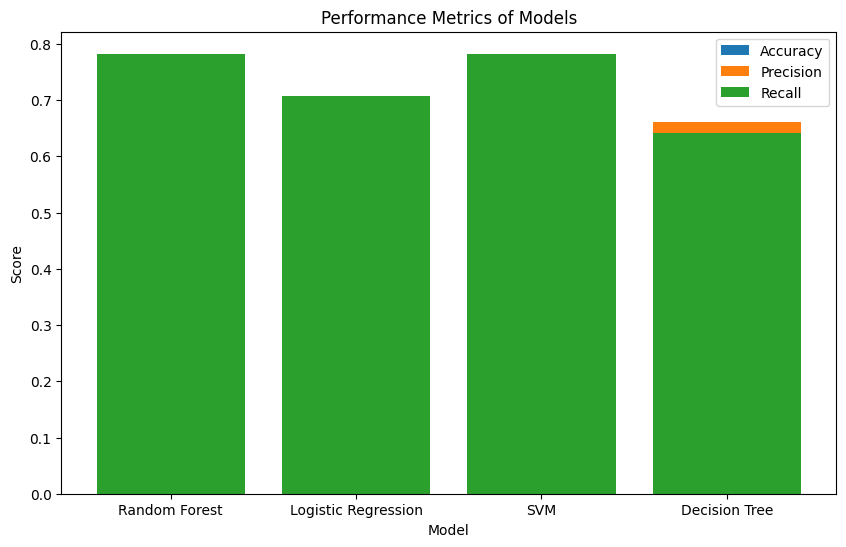

In [13]:
import matplotlib.pyplot as plt

# Lists to store metrics for each model
model_names = []
accuracies = []
precisions = []
recalls = []

# Loop through models and calculate metrics
for model_name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    # Append metrics to lists
    model_names.append(model_name)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)

# Plot metrics
plt.figure(figsize=(10, 6))

plt.bar(model_names, accuracies, label='Accuracy')
plt.bar(model_names, precisions, label='Precision')
plt.bar(model_names, recalls, label='Recall')

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Performance Metrics of Models')
plt.legend()

plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Assuming you already have your X and y (features and labels)

# Step 1: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Define models
models = [
    ("Random Forest", RandomForestClassifier()),
    ("SVM", SVC()),
    ("Logistic Regression", LogisticRegression()),
    ("Decision Tree", DecisionTreeClassifier())
]

# Step 3: Train and evaluate each model
for model_name, model in models:
    # Train the model
    model.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    # Print the evaluation metrics
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")


In [8]:
import pandas as pd

# Load the datasets
df_original = pd.read_csv('audio_dataset.csv')
df_augmented = pd.read_csv('audio_dataset_augmented.csv')

# Separate features and labels
X_original = df_original.drop(columns=['label'])
y_original = df_original['label']

X_augmented = df_augmented.drop(columns=['label'])
y_augmented = df_augmented['label']


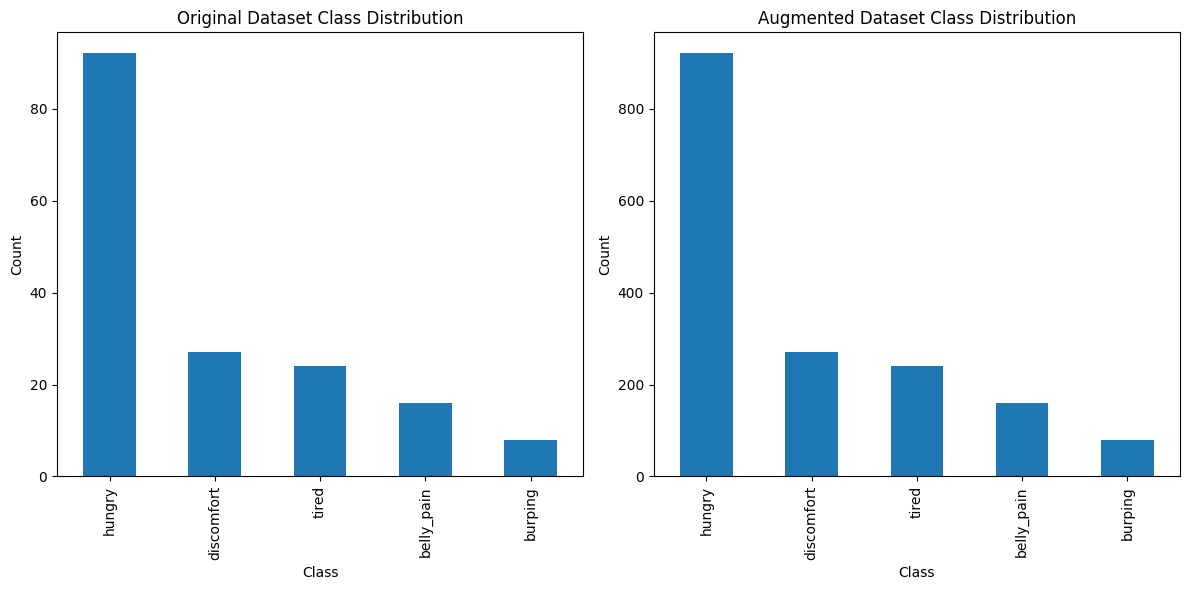

In [8]:
import matplotlib.pyplot as plt

# Plot the class distribution for the original dataset
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
y_original.value_counts().plot(kind='bar', title='Original Dataset Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

# Plot the class distribution for the augmented dataset
plt.subplot(1, 2, 2)
y_augmented.value_counts().plot(kind='bar', title='Augmented Dataset Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [9]:
# Calculate basic statistics for the original dataset
stats_original = X_original.describe().T
stats_original['variance'] = X_original.var()

# Calculate basic statistics for the augmented dataset
stats_augmented = X_augmented.describe().T
stats_augmented['variance'] = X_augmented.var()

# Compare statistics
stats_comparison = pd.DataFrame({
    'Original Mean': stats_original['mean'],
    'Augmented Mean': stats_augmented['mean'],
    'Original Std': stats_original['std'],
    'Augmented Std': stats_augmented['std'],
    'Original Variance': stats_original['variance'],
    'Augmented Variance': stats_augmented['variance']
})

print(stats_comparison)


      Original Mean  Augmented Mean  Original Std  Augmented Std  \
0       -497.783667     -324.892709    139.054951      45.360849   
1         56.563346     -274.103423     73.253688      58.096734   
10        -1.458605     -242.184096      5.709928      72.458576   
100     -476.568766       -2.845551    151.770149      17.896483   
1000    -329.865659       -0.242815    113.678291       3.438596   
...             ...             ...           ...            ...   
995        6.782283        0.000000     13.526510       0.000000   
996       -0.095743        0.000000     13.234476       0.000000   
997       -2.034241        0.000000     14.174554       0.000000   
998        6.579078        0.000000     15.141816       0.000000   
999       -5.067820        0.000000     13.124358       0.000000   

      Original Variance  Augmented Variance  
0          19336.279464         2057.606657  
1           5366.102797         3375.230474  
10            32.603275         5250.245275  

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split the original dataset
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_original, y_original, test_size=0.2, random_state=42)

# Split the augmented dataset
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=42)

# Define classifiers
classifiers = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC(kernel='linear', random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
}

# Function to train and evaluate classifiers
def evaluate_classifier(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=1)  # Set zero_division parameter
    conf_matrix = confusion_matrix(y_test, y_pred)
    return accuracy, report, conf_matrix

# Evaluate classifiers on the original dataset
results_original = {}
for name, clf in classifiers.items():
    accuracy, report, conf_matrix = evaluate_classifier(clf, X_train_orig, y_train_orig, X_test_orig, y_test_orig)
    results_original[name] = (accuracy, report, conf_matrix)

# Evaluate classifiers on the augmented dataset
results_augmented = {}
for name, clf in classifiers.items():
    accuracy, report, conf_matrix = evaluate_classifier(clf, X_train_aug, y_train_aug, X_test_aug, y_test_aug)
    results_augmented[name] = (accuracy, report, conf_matrix)

# Print results
for name in classifiers.keys():
    print(f"Classifier: {name}")
    print(f"Original Dataset Accuracy: {results_original[name][0]}")
    print(f"Original Dataset Classification Report: \n{results_original[name][1]}")
    print(f"Original Dataset Confusion Matrix: \n{results_original[name][2]}")
    print(f"Augmented Dataset Accuracy: {results_augmented[name][0]}")
    print(f"Augmented Dataset Classification Report: \n{results_augmented[name][1]}")
    print(f"Augmented Dataset Confusion Matrix: \n{results_augmented[name][2]}")
    print("\n")


Random Forest - Original Dataset
Accuracy: 0.5588235294117647
Classification Report: 
              precision    recall  f1-score   support

  belly_pain       1.00      0.00      0.00         3
     burping       1.00      0.00      0.00         3
  discomfort       1.00      0.00      0.00         5
      hungry       0.59      0.95      0.73        20
       tired       0.00      0.00      0.00         3

    accuracy                           0.56        34
   macro avg       0.72      0.19      0.15        34
weighted avg       0.67      0.56      0.43        34

Confusion Matrix: 
[[ 0  0  0  3  0]
 [ 0  0  0  3  0]
 [ 0  0  0  4  1]
 [ 0  0  0 19  1]
 [ 0  0  0  3  0]]

Random Forest - Augmented Dataset
Accuracy: 0.5449101796407185
Classification Report: 
              precision    recall  f1-score   support

  belly_pain       1.00      0.00      0.00        29
     burping       1.00      0.00      0.00        19
  discomfort       0.50      0.02      0.03        62
      hung

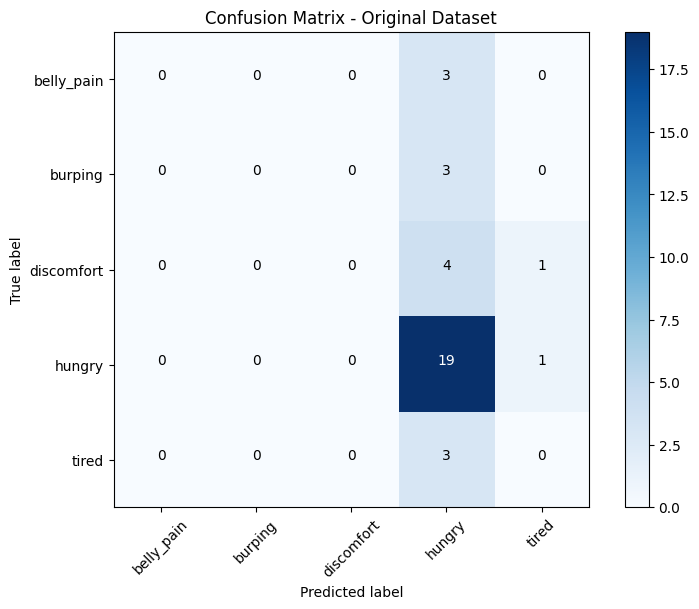

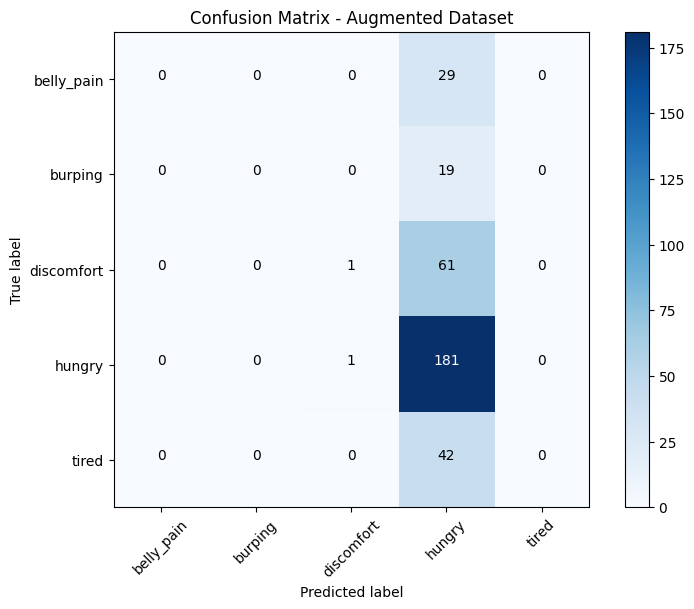

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import itertools

# Split the original dataset
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_original, y_original, test_size=0.2, random_state=42)

# Split the augmented dataset
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=42)

# Define the Random Forest classifier
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42, criterion='entropy', max_depth=32)

# Function to train and evaluate the Random Forest classifier
def evaluate_random_forest(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=1)
    conf_matrix = confusion_matrix(y_test, y_pred)
    return accuracy, report, conf_matrix

# Evaluate on the original dataset
accuracy_orig, report_orig, conf_matrix_orig = evaluate_random_forest(clf_rf, X_train_orig, y_train_orig, X_test_orig, y_test_orig)

# Evaluate on the augmented dataset
accuracy_aug, report_aug, conf_matrix_aug = evaluate_random_forest(clf_rf, X_train_aug, y_train_aug, X_test_aug, y_test_aug)

# Print results for the original dataset
print("Random Forest - Original Dataset")
print(f"Accuracy: {accuracy_orig}")
print(f"Classification Report: \n{report_orig}")
print(f"Confusion Matrix: \n{conf_matrix_orig}")

# Print results for the augmented dataset
print("\nRandom Forest - Augmented Dataset")
print(f"Accuracy: {accuracy_aug}")
print(f"Classification Report: \n{report_aug}")
print(f"Confusion Matrix: \n{conf_matrix_aug}")

import matplotlib.pyplot as plt
import numpy as np

# Define function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, classes, title):
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot confusion matrix for original dataset
plt.figure(figsize=(8, 6))
plot_confusion_matrix(conf_matrix_orig, classes=np.unique(y_test_orig), title='Confusion Matrix - Original Dataset')
plt.show()

# Plot confusion matrix for augmented dataset
plt.figure(figsize=(8, 6))
plot_confusion_matrix(conf_matrix_aug, classes=np.unique(y_test_aug), title='Confusion Matrix - Augmented Dataset')
plt.show()


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split the original dataset
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_original, y_original, test_size=0.2, random_state=42)

# Split the augmented dataset
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=42)

# Define the K-Nearest Neighbors classifier
clf_knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)

# Function to train and evaluate the K-Nearest Neighbors classifier
def evaluate_knn(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=1)
    conf_matrix = confusion_matrix(y_test, y_pred)
    return accuracy, report, conf_matrix

# Evaluate on the original dataset
accuracy_orig, report_orig, conf_matrix_orig = evaluate_knn(clf_knn, X_train_orig, y_train_orig, X_test_orig, y_test_orig)

# Evaluate on the augmented dataset
accuracy_aug, report_aug, conf_matrix_aug = evaluate_knn(clf_knn, X_train_aug, y_train_aug, X_test_aug, y_test_aug)

# Print results for the original dataset
print("K-Nearest Neighbors - Original Dataset")
print(f"Accuracy: {accuracy_orig}")
print(f"Classification Report: \n{report_orig}")
print(f"Confusion Matrix: \n{conf_matrix_orig}")

# Print results for the augmented dataset
print("\nK-Nearest Neighbors - Augmented Dataset")
print(f"Accuracy: {accuracy_aug}")
print(f"Classification Report: \n{report_aug}")
print(f"Confusion Matrix: \n{conf_matrix_aug}")


K-Nearest Neighbors - Original Dataset
Accuracy: 0.47058823529411764
Classification Report: 
              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         3
     burping       1.00      0.00      0.00         3
  discomfort       0.00      0.00      0.00         5
      hungry       0.68      0.75      0.71        20
       tired       0.20      0.33      0.25         3

    accuracy                           0.47        34
   macro avg       0.38      0.22      0.19        34
weighted avg       0.51      0.47      0.44        34

Confusion Matrix: 
[[ 0  0  0  3  0]
 [ 1  0  1  1  0]
 [ 1  0  0  2  2]
 [ 0  0  3 15  2]
 [ 0  0  1  1  1]]

K-Nearest Neighbors - Augmented Dataset
Accuracy: 0.5479041916167665
Classification Report: 
              precision    recall  f1-score   support

  belly_pain       0.26      0.28      0.27        29
     burping       0.50      0.16      0.24        19
  discomfort       0.45      0.31      0.37        

In [23]:
from sklearn.svm import SVC

# Define the Support Vector Machine classifier
clf_svm = SVC(kernel='rbf', random_state=42, C=12)

# Function to train and evaluate the Support Vector Machine classifier
def evaluate_svm(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=1)
    conf_matrix = confusion_matrix(y_test, y_pred)
    return accuracy, report, conf_matrix

# Evaluate on the original dataset
accuracy_orig, report_orig, conf_matrix_orig = evaluate_svm(clf_svm, X_train_orig, y_train_orig, X_test_orig, y_test_orig)

# Evaluate on the augmented dataset
accuracy_aug, report_aug, conf_matrix_aug = evaluate_svm(clf_svm, X_train_aug, y_train_aug, X_test_aug, y_test_aug)

# Print results for the original dataset
print("Support Vector Machine - Original Dataset")
print(f"Accuracy: {accuracy_orig}")
print(f"Classification Report: \n{report_orig}")
print(f"Confusion Matrix: \n{conf_matrix_orig}")

# Print results for the augmented dataset
print("\nSupport Vector Machine - Augmented Dataset")
print(f"Accuracy: {accuracy_aug}")
print(f"Classification Report: \n{report_aug}")
print(f"Confusion Matrix: \n{conf_matrix_aug}")


Support Vector Machine - Original Dataset
Accuracy: 0.5294117647058824
Classification Report: 
              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         3
     burping       1.00      0.00      0.00         3
  discomfort       0.00      0.00      0.00         5
      hungry       0.62      0.90      0.73        20
       tired       0.00      0.00      0.00         3

    accuracy                           0.53        34
   macro avg       0.32      0.18      0.15        34
weighted avg       0.45      0.53      0.43        34

Confusion Matrix: 
[[ 0  0  0  3  0]
 [ 0  0  0  3  0]
 [ 2  0  0  3  0]
 [ 0  0  1 18  1]
 [ 1  0  0  2  0]]

Support Vector Machine - Augmented Dataset
Accuracy: 0.5449101796407185
Classification Report: 
              precision    recall  f1-score   support

  belly_pain       1.00      0.00      0.00        29
     burping       1.00      0.00      0.00        19
  discomfort       1.00      0.00      0.00   

/home/kotaro/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/kotaro/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kotaro/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Multi-Layer Perceptron - Original Dataset
Accuracy: 0.5882352941176471
Classification Report: 
              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         3
     burping       0.00      0.00      0.00         3
  discomfort       0.00      0.00      0.00         5
      hungry       0.59      1.00      0.74        20
       tired       0.00      0.00      0.00         3

    accuracy                           0.59        34
   macro avg       0.12      0.20      0.15        34
weighted avg       0.35      0.59      0.44        34

Confusion Matrix: 
[[ 0  0  0  3  0]
 [ 0  0  0  3  0]
 [ 0  0  0  5  0]
 [ 0  0  0 20  0]
 [ 0  0  0  3  0]]

Multi-Layer Perceptron - Augmented Dataset
Accuracy: 0.5449101796407185
Classification Report: 
              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00        29
     burping       0.00      0.00      0.00        19
  discomfort       0.00      0.00      0.00   

/home/kotaro/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kotaro/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kotaro/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


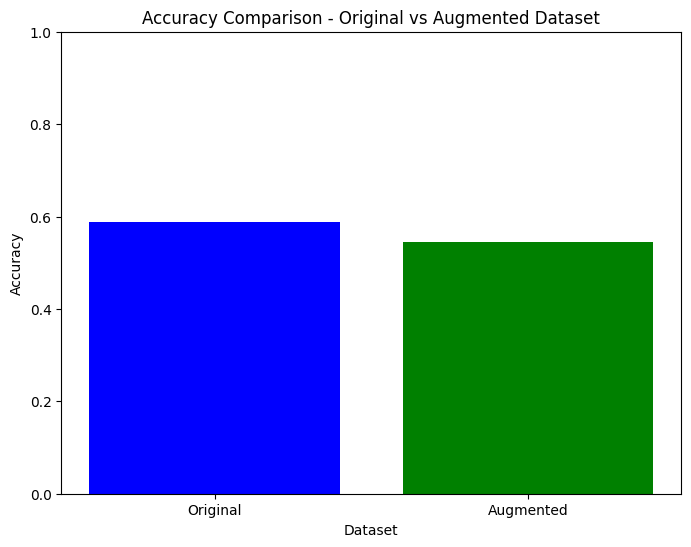

In [32]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define the Multi-Layer Perceptron classifier
clf_mlp = MLPClassifier(
    alpha=0.01,
    max_iter=1000,  # Increase the maximum number of iterations
    hidden_layer_sizes=(12,),
    solver='lbfgs',
    random_state=42)

# Function to train and evaluate the Multi-Layer Perceptron classifier
def evaluate_mlp(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division='warn')  # Set zero_division to 'warn'
    conf_matrix = confusion_matrix(y_test, y_pred)
    return accuracy, report, conf_matrix

# Evaluate on the original dataset
accuracy_orig, report_orig, conf_matrix_orig = evaluate_mlp(clf_mlp, X_train_orig, y_train_orig, X_test_orig, y_test_orig)

# Evaluate on the augmented dataset
accuracy_aug, report_aug, conf_matrix_aug = evaluate_mlp(clf_mlp, X_train_aug, y_train_aug, X_test_aug, y_test_aug)

# Print results for the original dataset
print("Multi-Layer Perceptron - Original Dataset")
print(f"Accuracy: {accuracy_orig}")
print(f"Classification Report: \n{report_orig}")
print(f"Confusion Matrix: \n{conf_matrix_orig}")

# Print results for the augmented dataset
print("\nMulti-Layer Perceptron - Augmented Dataset")
print(f"Accuracy: {accuracy_aug}")
print(f"Classification Report: \n{report_aug}")
print(f"Confusion Matrix: \n{conf_matrix_aug}")



import matplotlib.pyplot as plt

# Define data
datasets = ['Original', 'Augmented']
accuracies = [accuracy_orig, accuracy_aug]

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(datasets, accuracies, color=['blue', 'green'])
plt.title('Accuracy Comparison - Original vs Augmented Dataset')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # set y-axis limit from 0 to 1 for accuracy percentage
plt.show()


In [35]:


import os
import pickle
from sklearn.ensemble import RandomForestClassifier

def pickle_model(model, modelname):
    directory = 'models'
    if not os.path.exists(directory):
        os.makedirs(directory)
    with open(os.path.join(directory, str(modelname) + '.pkl'), 'wb') as f:
        pickle.dump(model, f)

# Define and train the Random Forest classifier
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42, criterion='entropy', max_depth=32)
clf_rf.fit(X_train, y_train)

# Save the Random Forest classifier
pickle_model(clf_rf, "myRandomForest")

def getModel(pickle_path):
  with open(pickle_path, 'rb') as f:
        return pickle.load(f)



In [36]:
predictions = []

folder_path = '../data/samples/'

for filename in os.listdir(folder_path):
    if filename.endswith(".wav"):
        try:
            audiofile, sr = librosa.load(os.path.join(folder_path, filename))
            fingerprint = librosa.feature.mfcc(y=audiofile, sr=sr, n_mfcc=20)
            fingerprint_flat = fingerprint.reshape(-1)  # Flatten the MFCC features
            # Pad or truncate features to match the number of features used for training
            if len(fingerprint_flat) < 2000:
                fingerprint_flat = np.pad(fingerprint_flat, (0, 2000 - len(fingerprint_flat)))
            elif len(fingerprint_flat) > 2000:
                fingerprint_flat = fingerprint_flat[:2000]
            prediction = model.predict([fingerprint_flat])  # Reshape to match expected input format
            predictions.append(prediction[0])
        except Exception as e:
            print(f"Error processing file {filename}: {e}")

from collections import Counter
data = Counter(predictions)
print(data)  # Returns all unique items and their counts

Error processing file 999bf14b-e417-4b44-b746-9253f81efe38-1430974001343-1.7-m-26-bp.wav: name 'model' is not defined
Error processing file 5afc6a14-a9d8-45f8-b31d-c79dd87cc8c6-1430757039803-1.7-m-48-bu.wav: name 'model' is not defined
Error processing file 643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138536-1.0-m-72-bp.wav: name 'model' is not defined
Error processing file 643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138647-1.0-m-72-bp.wav: name 'model' is not defined
Error processing file d6cda191-4962-4308-9a36-46d5648a95ed-1431159262344-1.7-m-04-bp.wav: name 'model' is not defined
Error processing file 7E4B9C14-F955-4BED-9B03-7F3096A6CBFF-1430232208-1.0-f-26-bu.wav: name 'model' is not defined
Error processing file F24DE44B-762C-4149-AC92-96A5E57ED118-1430816949-1.0-m-04-bu.wav: name 'model' is not defined
Error processing file 7A864194-4B6B-4850-ABBF-0C2A8170107B-1436846915-1.1-f-26-bu.wav: name 'model' is not defined
Error processing file 643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138524-1